## Robot programming workshop 02

<div class="alert alert-block alert-info">Below is a quick reminder of defining a class for OO programming in Python as this will be useful for managing the CoppeliaSim API in your robot experiments.</div>

### Object-orientation in Python

#### Classes in Python

###### Basic Syntax

<code><b>class</b> <font color="blue">name</font>(bases_class):
    <i>statements defining methods for the class</i></code>

<b>Example</b>

<code>class Area:           <font color="green">    # defines a class name "Area"</font>
    def <font color="blue">\_\_init\_\_</font>(<b>self</b>, x=0.0, y=0.0, w=0.0, h=0.0): <font color="green"># this method is the constructor - called when the object is created</font>
        self.x = x    <font color="green">     # <b>self</b> needs to be the first parameter for a method and allows the object to refer to itself</font>
        self.y = y
        self.w = w    <font color="green">     # these lines create and initialize the object attributes</font>
        self.h = h</code>
<code>    
    def <font color="blue">pointIn</font>(<b>self</b>, x, y): <font color="green">   # defines a method</font>
        return (self.x <= x <= self.x + self.w && 
                self.y <= y <= self.y + self.h)</code>
<code>
    def <font color="blue">move</font>(<b>self</b>, dx, dy):
        self.x += dx
        self.y += dy</code><br>
    .<br>
    .<br>
    .<br>
<code>inst = Area(1.0, 1.0, 4.0, 4.0)  <font color="green"># create an object instance</font> 
inst.move(3, 5)             <font color="green">      # calls a method</font>
</code>

<div class="alert alert-block alert-info">For this workshop you will writing a wrapper class for the line tracer robot before designing a line tracing algorithm and implementing your design to control the line tracer robot in the CoppeliaSim environment. Make sure you have save sim.py, simConst.py and remoteApi.dll files to a directory and also downloaded the 01_line_tracker_scene.ttt to the same location</div>

<font color="red"><b>Task 1:</b></font> Change directory - to the working directory where you have saved <b>sim.py, simConst.py</b> and <b>remoteApi.dll</b>  

In [1]:
import sys, os
desiredPath = "C:\\Users\\User\\OneDrive\\Desktop\\Robotics2\\Robotics\\Robotics\\Files" # set this path to your working folder
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd())) # sanity check

Current working directory: C:\Users\User\OneDrive\Desktop\Robotics2\Robotics\Robotics\Files


In [2]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time, sys, os

<font color="red"><b>Task 3:</b></font> Below is the implementation of a wrapper class for Pioneer robot (use this as a general guide for the format of what is required (only use as a structure guide)  I've written a similar wrapper for the line tracer robot but it is incomplete. Complete the class and test it in task 4 

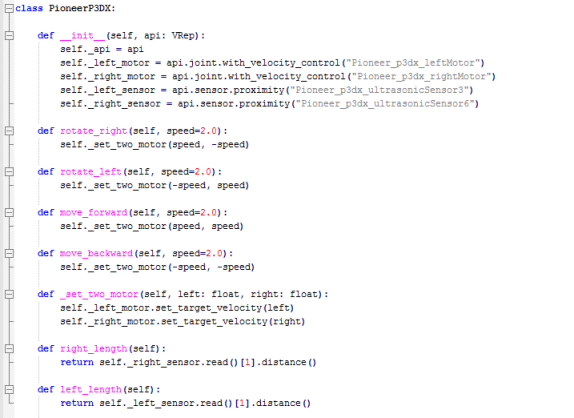

In [3]:
import time
class LineTracerRobot:

    def __init__(self, sim, clientID):
        self._sim = sim
        self.clientID = clientID 
        errCode = [0] * 5
        ## attach actuators and sensors
        errCode[0], self.leftMotor = sim.simxGetObjectHandle(clientID, "DynamicLeftJoint", sim.simx_opmode_oneshot_wait )
        errCode[1], self.rightMotor = sim.simxGetObjectHandle(clientID, "DynamicRightJoint", sim.simx_opmode_oneshot_wait )
        errCode[2], self.leftSensor = sim.simxGetObjectHandle(clientID, "LeftSensor", sim.simx_opmode_oneshot_wait )
        errCode[3], self.rightSensor = sim.simxGetObjectHandle(clientID, "RightSensor", sim.simx_opmode_oneshot_wait )
        errCode[4], self.midSensor = sim.simxGetObjectHandle(clientID, "MiddleSensor", sim.simx_opmode_oneshot_wait )
        
        
    def _set_two_motor(self, left: float, right: float):
        sim.simxSetJointTargetVelocity(self.clientID, self.leftMotor, left, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(self.clientID, self.rightMotor, right, sim.simx_opmode_oneshot_wait)
    
    def __bool__(self):
        return self.right_sensor and self.mid_sensor and self.left_sensor
    
    
    def get_sensors(self):
        return self.left_sensor, self.mid_sensor, self.right_sensor

    
    def right_sensor(self):
        ## return the value from the rigth sensor
        return self._sim.simxReadVisionSensor(self.clientID,self.rightSensor,self._sim.simx_opmode_oneshot_wait)[1]
    
    
    def mid_sensor(self):
        ## return the value from the middle sensor
        return self._sim.simxReadVisionSensor(self.clientID,self.midSensor,self._sim.simx_opmode_oneshot_wait)[1]
            
    
    def left_sensor(self):
        ## return the value from the left sensor
        return self._sim.simxReadVisionSensor(self.clientID,self.leftSensor,self._sim.simx_opmode_oneshot_wait)[1]
        
        
    def rotate_right(self, speed=2.0):
        ## turn the robot right
        self._set_two_motor(speed, -speed)

    def rotate_left(self, speed=2.0):
        ## turn the robot left
        self._set_two_motor(-speed, 
                            speed)
    def move_forward(self, speed=2.0):
        ## move the robot forward
        self._set_two_motor(speed, speed)
        
        
    def move_backward(self, speed=2.0):
        ## move the robot backwards
        self._set_two_motor(-speed, -speed)
        
    def stop(self):
        ## stop the robot
        self._set_two_motor(0.0, 0.0)


<font color="red"><b>Task 4:</b></font> Run the robot and read the sensor data

### A line following algorithm

The aim of the line following robot is to detect the black line through its sensors and as long as it can see the line through its 3 sensors it should keep moving forward.

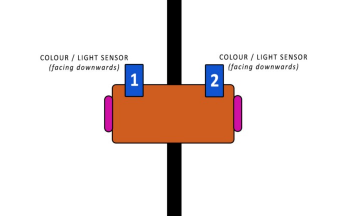

<b>Description of the line following algorithm</b><br>There are three cases for the line follower, finding the line, getting onto the line and staying on the line.
If no line is detected can make a random walk or at the very least move forward (or backward) in the hope of finding the line.
If the robot is not on the line and only one of the sensors detects a black line (it is usually either the left or the right), then the robot must steer in the direction of that sensor right to get onto the line.
If the robot is following the line and one of the sensors slips off the line the robot should steer in the opposite direction to move back onto the line.  For instance if the left sensor slips off the line the robot should steer more right to recover its path.  


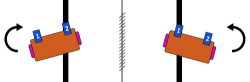

<font color="red"><b>Task 5:</b></font> Below is a simple algorithm for the for a line following robot but it is for a robot that only has 2 sensors not 3 and for a robot where the line is thinner than the width of the sensors (see the diagrams above).  Redesign the algorithm for for our line following robot which has 3 sensors and all the sensors are over the line as the robot follows it.


<code>if right_sensor detects black
    ## Move Right 
    set left motor ON
    set right motor OFF
else if left_sensor detects black 
    ## Move Left
    set left motor OFF
    set right motor ON
else if right_sensor and left sensor do not detect black
    ##  Could do other things to search for the line
    set left motor ON
    set right motor ON
else if left_sensor and right_sensor detect black 
    ##  Follow the line
    set left motor ON
    set right motor ON
endif</code>

<font color="red"><b>Task 6:</b></font> Implement the line following algorithm you have designed for task 5 using the robot class that you have implemented for task 3 and test you program in the Coppeliasim simulator. 

In [ ]:
print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections

clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

if clientID != -1:
    print ('Connected to remote API server')
else:
    print('Connection failed!!')
    sys.exit('Could not connect')


TimeOutLimit = 500000

bot = LineTracerRobot(sim, clientID)

startTime = time.time()

while time.time()-startTime < TimeOutLimit:
    sensorReading = [bot.left_sensor(), bot.mid_sensor(), bot.right_sensor()]
    print(sensorReading)
    
    
    if sensorReading[1] == False and sensorReading[0] == False and sensorReading[2] == False:
        bot.move_forward(0.7)
        
    elif sensorReading[2] == False and sensorReading[1] == False and sensorReading[0] == True:
        bot.rotate_right(0.2)

    elif sensorReading[2] == False and sensorReading[1] == True and sensorReading[0] == True:
        bot.rotate_right(0.4)
        
    elif sensorReading[0] == False and sensorReading[1] == False and sensorReading[2] == True:
        bot.rotate_left(0.2)
    
    elif sensorReading[0] == False and sensorReading[1] == True and sensorReading[2] == True:
        bot.rotate_left(0.4)
        
    elif sensorReading[0] == True and sensorReading[1] == True and sensorReading[2] == True:
         bot.move_forward(0.7)
    
    else:
        bot.move_forward(0.7)
    
    
    time.sleep(0.2)

bot.stop()
time.sleep(0.5)
sim.simxFinish(-1)
print("...done")

Program started
Connected to remote API server
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, True, True]
[True, 

[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[True, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[True, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[True, False, False]
[True, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False,

[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, False]
[True, False, True]
[False, False, True]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, True]
[False, False, False]
[False, False, False]
[False, False, True]


[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, False, False]
[False, Fa

<div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: we will add some logical structure and OO design to our robot code. </div>